<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/Simulating_Gravitational_Lensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

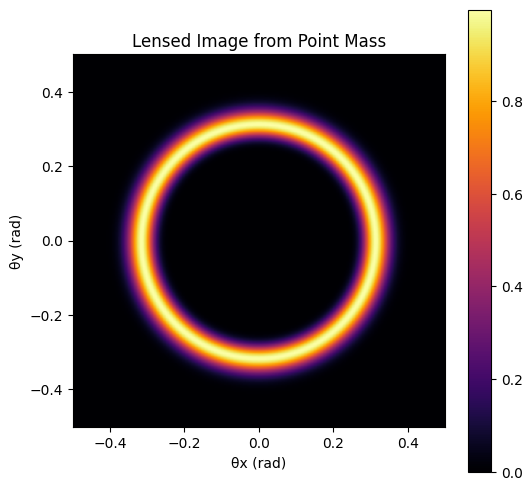

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

G = 1
c = 1
Distance_source = 1.0
Distance_lens = 0.5
Distance_ls = Distance_source - Distance_lens

def deflection_angle(theta_x, theta_y, M):
    r_squared = theta_x**2 + theta_y**2 + 1e-8
    alpha_x = 4 * G * M / c**2 * theta_x / r_squared
    alpha_y = 4 * G * M / c**2 * theta_y / r_squared
    return alpha_x, alpha_y

def gaussian_source(x, y, x0 = 0, y0 = 0, sigma=0.05):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

npix = 256
fov = 1.0

x = np.linspace(-fov/2, fov/2, npix)
y = np.linspace(-fov/2, fov/2, npix)
theta_x, theta_y = np.meshgrid(x, y)

M = 0.05

alpha_x, alpha_y = deflection_angle(theta_x, theta_y, M)

beta_x = theta_x - (Distance_ls / Distance_source) * alpha_x
beta_y = theta_y - (Distance_ls / Distance_source) * alpha_y

source_x = x
source_y = y
source_grid_x, source_grid_y = np.meshgrid(source_x, source_y)

source_plane = gaussian_source(source_grid_x, source_grid_y, x0 = 0.0, y0 = 0.0)

scale = npix / fov
coords_x = (beta_x + fov / 2) * scale
coords_y = (beta_y + fov / 2) * scale
coords = np.array([coords_y.flatten(), coords_x.flatten()])

lensed_image = map_coordinates(source_plane, coords, order = 1).reshape((npix, npix))

plt.figure(figsize = (6, 6))
plt.imshow(lensed_image, extent = [-fov / 2, fov / 2, -fov / 2, fov / 2], origin = 'lower', cmap = 'inferno')
plt.title('Lensed Image from Point Mass')
plt.xlabel('θx (rad)')
plt.ylabel('θy (rad)')
plt.colorbar()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 290.28it/s]


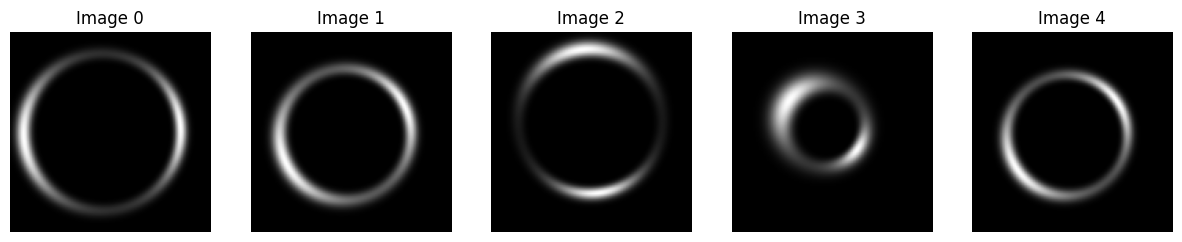

In [32]:
import os
from tqdm import tqdm
from PIL import Image
import glob

os.makedirs('simulated_lenses', exist_ok = True)

def save_image(array, filename):
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    image = (array * 255).astype(np.uint8)
    Image.fromarray(image).save(filename)

def generate_lensed_image(mass, x0, y0, sigma = 0.05, npix = 128, fov = 1.0):
    x = np.linspace(-fov / 2, fov / 2, npix)
    y = np.linspace(-fov / 2, fov / 2, npix)
    theta_x, theta_y = np.meshgrid(x, y)

    alpha_x, alpha_y = deflection_angle(theta_x, theta_y, mass)
    beta_x = theta_x - (Distance_ls / Distance_source) * alpha_x
    beta_y = theta_y - (Distance_ls / Distance_source) * alpha_y

    source_x = x
    source_y = y
    source_grid_x, source_grid_y = np.meshgrid(source_x, source_y)
    source_plane = gaussian_source(source_grid_x, source_grid_y, x0, y0, sigma)

    scale = npix / fov
    coords_x = (beta_x + fov / 2) * scale
    coords_y = (beta_y + fov / 2) * scale
    coords = np.array([coords_y.flatten(), coords_x.flatten()])
    lensed_image = map_coordinates(source_plane, coords, order = 1).reshape((npix, npix))

    return lensed_image

n_images = 500
npix = 128
fov = 1.0

for i in tqdm(range(n_images)):
    mass = np.random.uniform(0.01, 0.1)
    x0 = np.random.uniform(-0.1, 0.1)
    y0 = np.random.uniform(-0.1, 0.1)
    sigma = np.random.uniform(0.02, 0.07)

    img = generate_lensed_image(mass, x0, y0, sigma, npix, fov)
    save_image(img, f'simulated_lenses/lens_{i:04d}.png')

image_paths = sorted(glob.glob('simulated_lenses/*.png'))[:5]

plt.figure(figsize = (15, 3))
for i, path in enumerate(image_paths):
    img = Image.open(path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title(f'Image {i}')
plt.show()

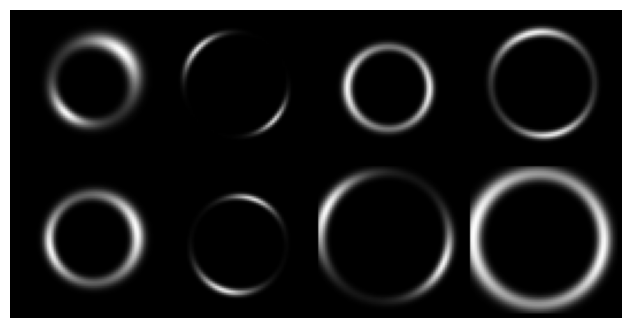

In [36]:
!pip install torch torchvision

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torchvision # Import torchvision

class LensedImageDataset(Dataset):
    def __init__(self, image_dir, transform = None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,])
])

dataset = LensedImageDataset('simulated_lenses', transform = transform)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 2)

images = next(iter(dataloader))
grid = torchvision.utils.make_grid(images[:8], nrow = 4, normalize = True)
plt.figure(figsize = (8, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap = 'gray')
plt.axis('off')
plt.show()

In [37]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [38]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        output = self.model(img_flat)
        return output

In [39]:
adversarial_loss = nn.BCEWithLogitsLoss()

latent_dim = 100
img_shape = (64, 64)

generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

optimizer_G = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

print(f"Using device: {device}")

Using device: cpu


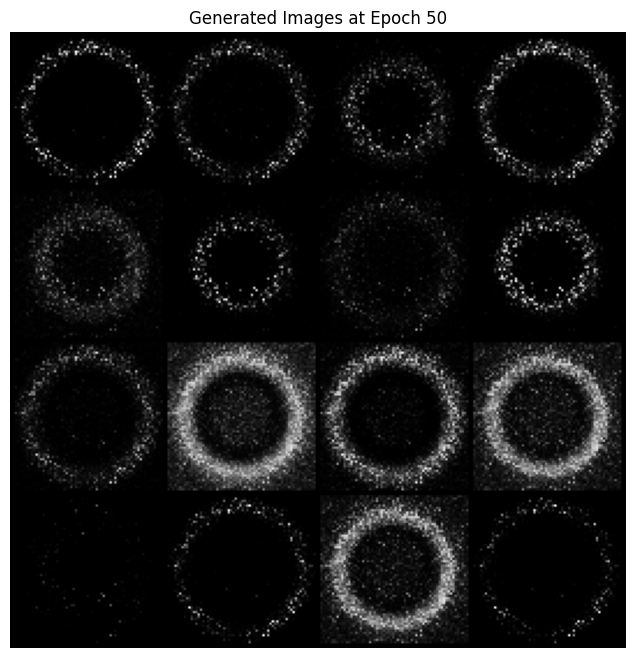

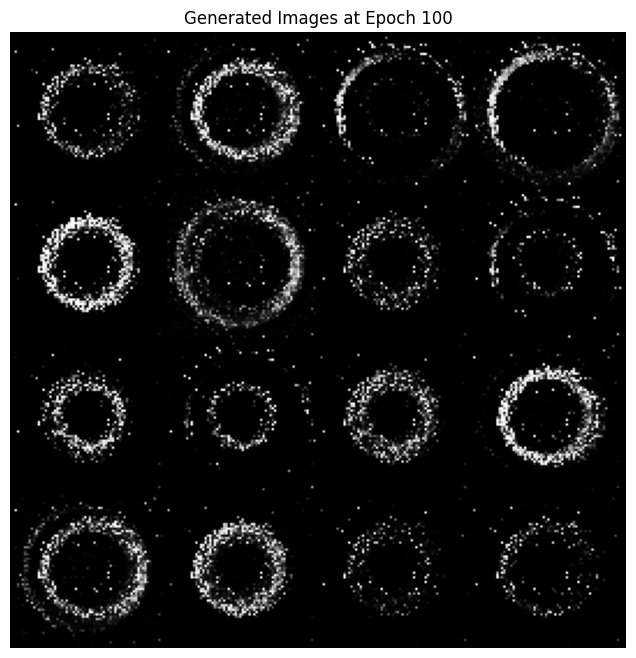

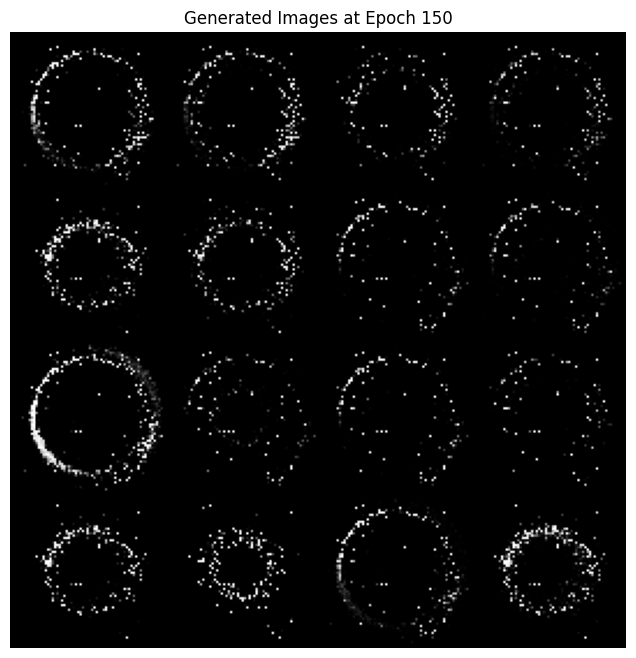

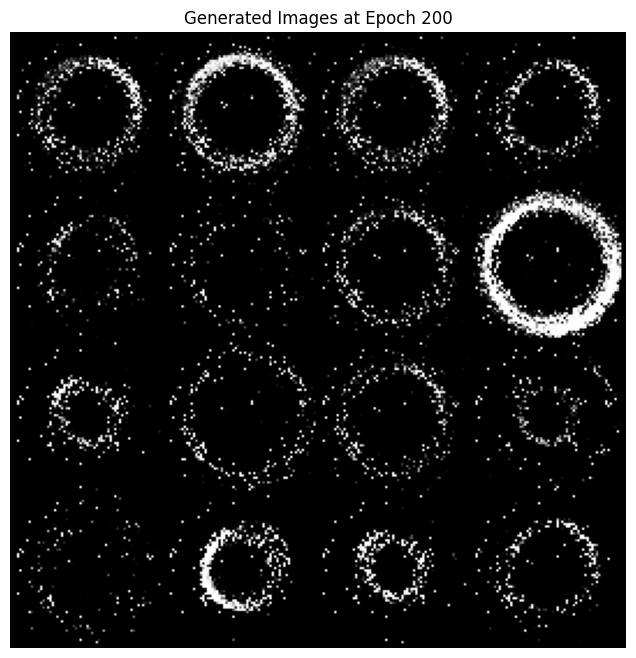

In [42]:
n_epochs = 200

for epoch in range(n_epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_labels = torch.ones(batch_size, 1, device = device)
        outputs_real = discriminator(real_images)
        loss_D_real = adversarial_loss(outputs_real, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim, device = device)
        fake_images = generator(z).detach()
        fake_labels = torch.zeros(batch_size, 1, device = device)
        outputs_fake = discriminator(fake_images)
        loss_D_fake = adversarial_loss(outputs_fake, fake_labels)

        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, device = device)
        generated_images = generator(z)
        gen_labels = torch.ones(batch_size, 1, device = device)
        outputs_gen = discriminator(generated_images)
        loss_G = adversarial_loss(outputs_gen, gen_labels)

        loss_G.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(dataloader)}], D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device = device)
            generated_images = generator(z).cpu()
            # Add channel dimension if it's missing (for grayscale)
            if generated_images.ndim == 3:
                 generated_images = generated_images.unsqueeze(1)
            grid = torchvision.utils.make_grid(generated_images, nrow = 4, normalize = True)
            plt.figure(figsize = (8, 8))
            # Permute and remove the channel dimension for imshow
            plt.imshow(grid.permute(1, 2, 0).squeeze(-1), cmap = 'gray')
            plt.axis('off')
            plt.title(f'Generated Images at Epoch {epoch + 1}')
            plt.show()


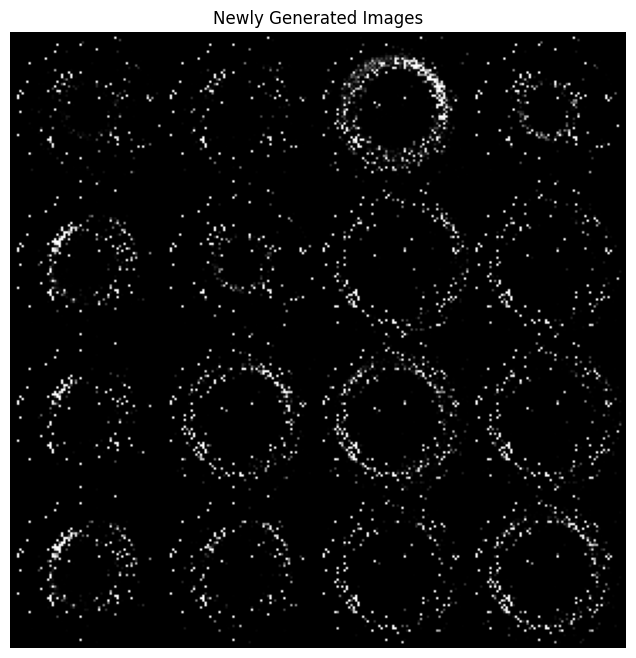

In [43]:
generator.eval()
num_generate = 16
with torch.no_grad():
    z = torch.randn(num_generate, latent_dim, device=device)
    generated_images = generator(z).cpu()

if generated_images.ndim == 3:
    generated_images = generated_images.unsqueeze(1)

grid = torchvision.utils.make_grid(generated_images, nrow=4, normalize=True)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(-1), cmap='gray')
plt.axis('off')
plt.title('Newly Generated Images')
plt.show()